In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.models import vgg16
import shutil

# Data

In [2]:
cmaps = os.listdir('cmaps')
maps = []
for map in cmaps:
    max_size = 408
    im_reshape = np.zeros((max_size, max_size))
    im = np.asarray(Image.open(os.path.join('cmaps', map)))
    im_correct = im[im.any(axis=1)][:, im.any(axis=0)]
    n, p = im_correct.shape
    # The data is rescalde between 0 and 1
    im_rescale = im_correct
    # Center and reshape the data
    im_rescale = np.pad(im_rescale, [((max_size - n) // 2, (max_size - n) - (max_size - n) // 2), ((max_size - p) // 2, (max_size - p) - (max_size - p) // 2)])
    maps.append(im_rescale[None,:,:].repeat(3, axis=0).astype(np.float32))

# Extract features with vgg16

In [3]:
maps_tensor = torch.tensor(np.array(maps))
features = vgg16()

In [4]:
features_exrracted = []
start = 0
for batch in range(0, len(maps) + 10, 10):
    featur = features.forward(maps_tensor[start:batch]).detach().numpy()
    features_exrracted.append(featur)
    start = batch

In [5]:
featur_exrracted = []
for i in features_exrracted:
    for j in i:
        featur_exrracted.append(j)
featur_extracted = np.array(featur_exrracted)
np.savez_compressed('features_v166', features = featur_extracted)

## PCA for the extracted features

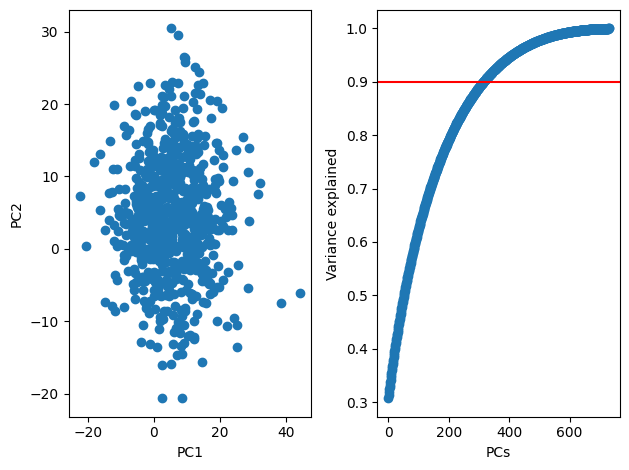

In [10]:
S, V, D = np.linalg.svd(featur_extracted)
fig, ax = plt.subplots(1,2)
ax[0].scatter(featur_extracted @ D[:,0], featur_extracted @ D[:,1])
ax[1].plot(np.arange(V.shape[0]) + 1, np.cumsum(V ** 2) / np.sum(V ** 2))
ax[1].scatter(np.arange(V.shape[0]) + 1, np.cumsum(V ** 2) / np.sum(V ** 2))
ax[1].axhline(0.9, c = 'red')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PCs')
ax[1].set_ylabel('Variance explained')
plt.tight_layout()
plt.savefig('pcs_projection.png')
plt.show()

## Clustering on these features

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, init = "random", n_init = 10, random_state = 0).fit(featur_extracted)
cluster_des = kmeans.fit_predict(featur_extracted)

### Gap statistics for number of clusters ?

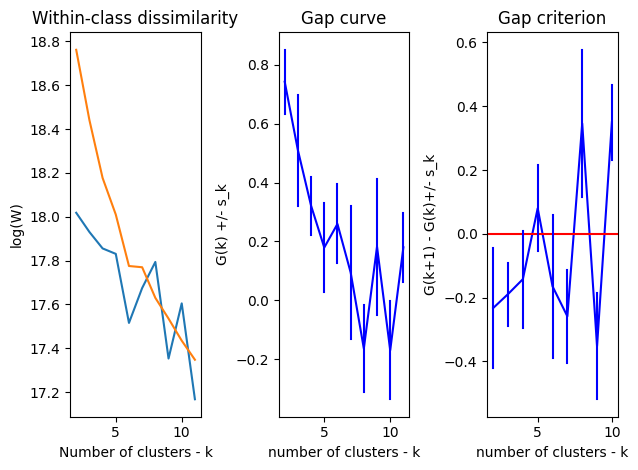

<Figure size 1200x900 with 0 Axes>

In [14]:
# minimum of 2 clusters
list_cluster = 2 + np.arange(10)
Nsim = 20
W = np.zeros(len(list_cluster))
Wu = np.zeros((len(list_cluster), Nsim))
[N, p] = featur_extracted.shape
minX = list(np.min(featur_extracted, axis=0)) # data range min
maxX = list(np.max(featur_extracted, axis=0)) # data range max
for idx, i in enumerate(list_cluster):
    kmeans = KMeans(n_clusters = i, init = "random", n_init = 10, random_state = 0, max_iter = 1 + len(list_cluster)).fit(featur_extracted)
    # Within class dissimilarity
    kmeans.fit_predict(featur_extracted)
    W[idx] = np.sum([len(featur_extracted[kmeans.labels_ == k]) * np.sum(np.linalg.norm(featur_extracted[kmeans.labels_ == k] - kmeans.cluster_centers_[k], axis = 1)) for k in range(i)])
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        
        # perform K-means on the simulated data
        kmeans_sim = KMeans(n_clusters = i, init = "random", n_init = 1, random_state = 0, max_iter = 1 + len(list_cluster))
        kmeans_sim.fit_predict(Xu)
        # Within class dissimilarity (the simulated data)
        Wu[idx,j] = np.sum([len(Xu[kmeans_sim.labels_ == k]) * np.sum(np.linalg.norm(Xu[kmeans_sim.labels_ == k] - kmeans_sim.cluster_centers_[k], axis = 1)) for k in range(i)])

# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
plt.figure(figsize=(12,9))
fig, ax = plt.subplots(1, 3)
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) 
x_range = np.array(list_cluster)

# Plot the log within class scatters
ax[0].set_title("Within-class dissimilarity")
ax[0].plot(x_range, np.log(W), label='observed')
ax[0].plot(x_range, Elog_Wu, label='expected for simulation')
ax[0].set_xlabel("Number of clusters - k")
ax[0].set_ylabel("log(W)")

 # plot the Gap curve
ax[1].set_title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
ax[1].plot(x_range,Gk,color='blue')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
ax[1].plot(x_range_list, GkList, color='blue')
ax[1].set_ylabel('G(k) +/- s_k')
ax[1].set_xlabel('number of clusters - k')

# plot the Gap criterion
x_range_crit = x_range[:-1]
ax[2].set_title('Gap criterion')
Gk_crit =  Gk[1:] - Gk[:-1]
sk_crit = sk[1:]
ax[2].plot(x_range_crit, Gk_crit, color='blue')
x_range_list = []
x_range_list.append(x_range_crit)
x_range_list.append(x_range_crit)
GkList = []
GkList.append(Gk_crit-sk_crit)
GkList.append(Gk_crit+sk_crit)
ax[2].axhline(0, color = 'red')
ax[2].plot(x_range_list, GkList, color='blue')
ax[2].set_ylabel('G(k+1) - G(k)+/- s_k')
ax[2].set_xlabel('number of clusters - k')
plt.tight_layout()
plt.show()

In [29]:
# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = np.max(list_cluster)
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_cluster[K_opt[0]])

Gap-statistic, optimal K = 3


# Taking flattened maps to compare

In [16]:
flatten_maps = []
shape = []
for map in cmaps:
    im = np.asarray(Image.open(os.path.join('cmaps', map)))
    im_correct = im[im.any(axis=1)][:, im.any(axis=0)]
    n, p = im_correct.shape
    shape.append(n)
    im_rescale = - (im_correct // 255) + 1
    im_rescale = np.pad(im_rescale, [(0, 408 - n), (0, 408 - p)])

    flatten_maps.append(im_rescale.reshape(-1))
shape = np.array(shape)
flatten_maps = np.array(flatten_maps)

0
1
2
3
4
5
6
7
8
9


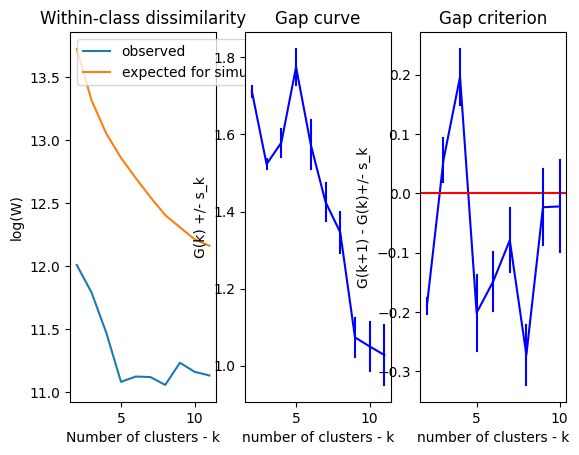

<Figure size 1200x900 with 0 Axes>

In [11]:
# minimum of 2 clusters
list_cluster = 2 + np.arange(10)
Nsim = 20
W = np.zeros(len(list_cluster))
Wu = np.zeros((len(list_cluster), Nsim))
flatten_maps = flatten_maps[:,:300]
[N, p] = flatten_maps.shape
minX = list(np.min(flatten_maps, axis=0)) # data range min
maxX = list(np.max(flatten_maps, axis=0)) # data range max
for idx, i in enumerate(list_cluster):
    kmeans = KMeans(n_clusters = i, init = "random", n_init = 10, random_state = 0, max_iter = 1 + len(list_cluster)).fit(flatten_maps)
    # Within class dissimilarity
    kmeans.fit_predict(flatten_maps)
    W[idx] = np.sum([len(flatten_maps[kmeans.labels_ == k]) * np.sum(np.linalg.norm(flatten_maps[kmeans.labels_ == k] - kmeans.cluster_centers_[k], axis = 1)) for k in range(i)])
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        
        # perform K-means on the simulated data
        kmeans_sim = KMeans(n_clusters = i, init = "random", n_init = 1, random_state = 0, max_iter = 1 + len(list_cluster))
        kmeans_sim.fit_predict(Xu)
        # Within class dissimilarity (the simulated data)
        Wu[idx,j] = np.sum([len(Xu[kmeans_sim.labels_ == k]) * np.sum(np.linalg.norm(Xu[kmeans_sim.labels_ == k] - kmeans_sim.cluster_centers_[k], axis = 1)) for k in range(i)])

# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
fig, ax = plt.subplots(1, 3)
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) 
x_range = np.array(list_cluster)

# Plot the log within class scatters
ax[0].set_title("Within-class dissimilarity")
ax[0].plot(x_range, np.log(W), label='observed')
ax[0].plot(x_range, Elog_Wu, label='expected for simulation')
ax[0].legend(loc='upper left')
ax[0].set_xlabel("Number of clusters - k")
ax[0].set_ylabel("log(W)")

 # plot the Gap curve
ax[1].set_title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
ax[1].plot(x_range,Gk,color='blue')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
ax[1].plot(x_range_list, GkList, color='blue')
ax[1].set_ylabel('G(k) +/- s_k')
ax[1].set_xlabel('number of clusters - k')

# plot the Gap criterion
x_range_crit = x_range[:-1]
ax[2].set_title('Gap criterion')
Gk_crit =  Gk[1:] - Gk[:-1]
sk_crit = sk[1:]
ax[2].plot(x_range_crit, Gk_crit, color='blue')
x_range_list = []
x_range_list.append(x_range_crit)
x_range_list.append(x_range_crit)
GkList = []
GkList.append(Gk_crit-sk_crit)
GkList.append(Gk_crit+sk_crit)
ax[2].axhline(0, color = 'red')
ax[2].plot(x_range_list, GkList, color='blue')
ax[2].set_ylabel('G(k+1) - G(k)+/- s_k')
ax[2].set_xlabel('number of clusters - k')
plt.figure(figsize=(12,9))
plt.tight_layout()
plt.show()

In [17]:
# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = np.max(list_cluster)
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_cluster[K_opt[0]])

Gap-statistic, optimal K = 2


## Clustering on flattened maps

In [18]:
from sklearn.cluster import KMeans

kmeans_flatten = KMeans(n_clusters = 7, init = "random", n_init = 10, random_state = 0).fit(flatten_maps)
cluster_des_flatten = kmeans_flatten.fit_predict(flatten_maps)

## Silhouette plots

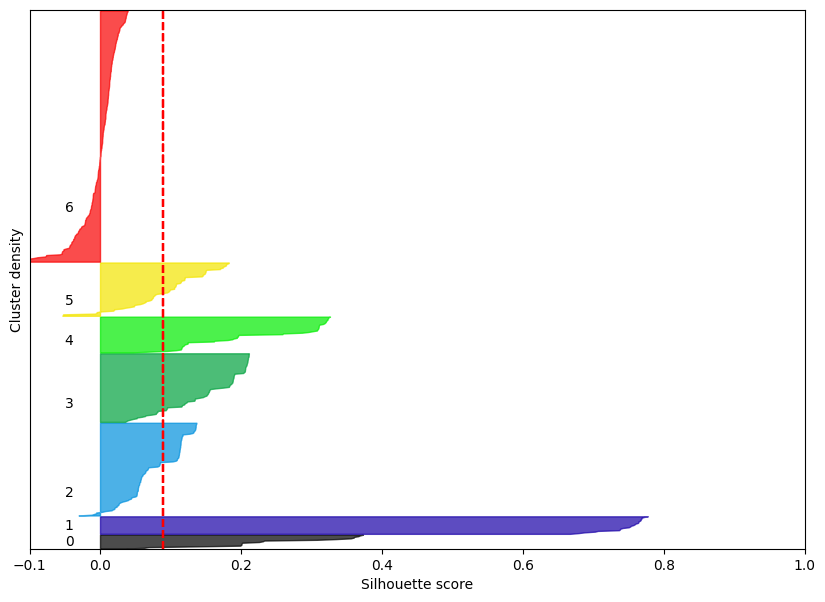

In [20]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 7)   
n_clusters = 7
silhouette_sampl = silhouette_samples(flatten_maps, cluster_des_flatten)
silhouette_scores = silhouette_score(flatten_maps, cluster_des_flatten)
space = 0.2
y_lower = 0.2
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_sampl[cluster_des_flatten == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    # drawing silhouettes
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.set_ylim([0, len(flatten_maps) + (n_clusters + 1) * space])
    ax.set_xlim([-0.1, 1])
    y_upper = y_lower + size_cluster_i
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax.axvline(silhouette_scores, color = 'red', linestyle = 'dashed')

    # Label the silhouette plots with their cluster numbers at the middle
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.text(-0.05, y_lower + 0.2 * size_cluster_i, str(i))
    ax.set_xlabel('Silhouette score')
    ax.set_ylabel('Cluster density')
    y_lower = y_upper + space
plt.savefig('silhouette_plot.png')

# Comparing the two approaches

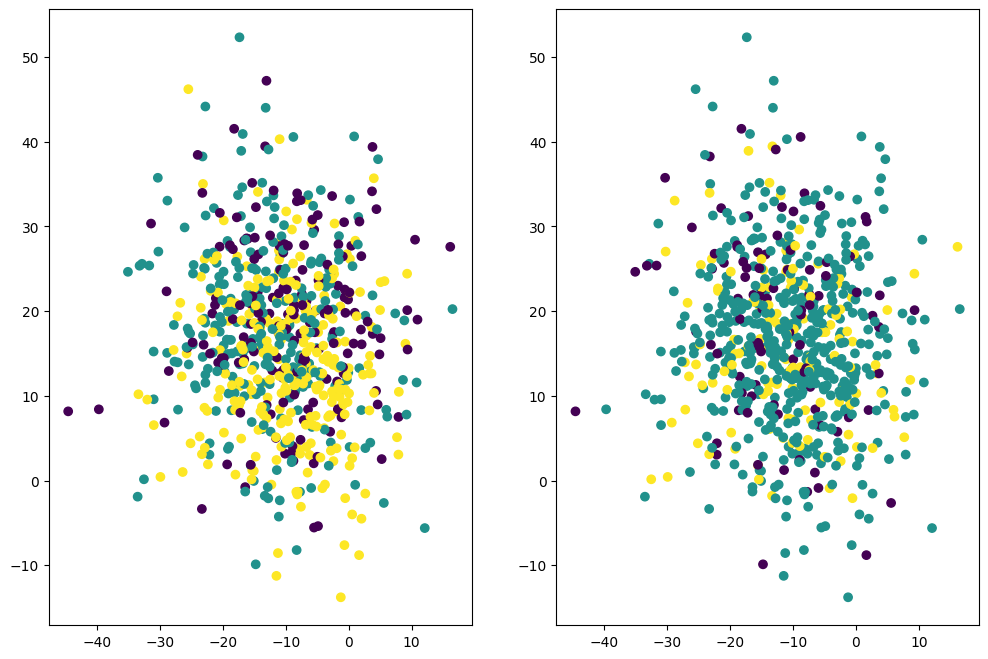

In [32]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,8)
ax[0].scatter(featur_extracted @ D[:,0], featur_extracted @ D[:,1], c = cluster_des / max(cluster_des))
ax[1].scatter(featur_extracted @ D[:,0], featur_extracted @ D[:,1], c = cluster_des_flatten[:730] / max(cluster_des_flatten[:730]))
plt.show()

## Analyzing resulting clusters shape

In [53]:
n_clusters = 2
# Where are the 1st quantile ?
w_0 = shape[np.arange(len(cluster_des_flatten))[cluster_des_flatten == 0]]
w_1 = shape[np.arange(len(cluster_des_flatten))[cluster_des_flatten == 1]]

In [74]:
w_00 = len(w_0[w_0 <= np.quantile(shape, 1/n_clusters)])
w_01 = len(w_0[w_0 > np.quantile(shape, 1/n_clusters)])
w_11 = len(w_1[w_1 > np.quantile(shape, 1/n_clusters)])
w_10 = len(w_1[w_1 <=  np.quantile(shape, 1/n_clusters)])

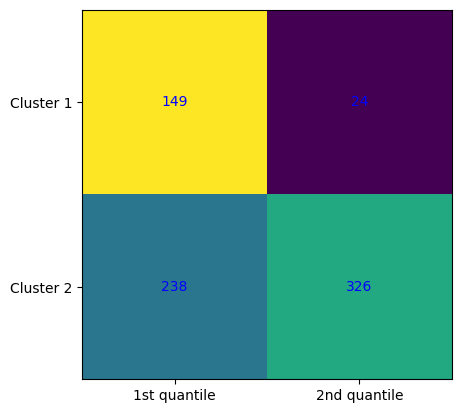

In [88]:
quantile = np.array([[w_00, w_01],
                      [w_10, w_11]])
normalized_quantile = np.array([[w_00/ len(w_0), w_01/len(w_0)],
                      [w_10/len(w_1), w_11/len(w_1)]])
plt.imshow(normalized_quantile)
for i in range(len(quantile)):
    for j in range(len(quantile[i])):
        plt.text(j, i, quantile[i, j], ha="center", va="center", color="b")
plt.xticks(np.arange(2), ["1st quantile", "2nd quantile"])
plt.yticks(np.arange(2), ["Cluster 1", "Cluster 2"])
plt.show()

## Anlayzing resultings clusters class

In [4]:
data

,acno,domain,interval
0,A0A068A244,"['PF02876', 'PF01123']","[[147,254],[49,137]]"
1,A0A075M4C7,"['PF01123', 'PF02876']","[[78,166],[176,283]]"
2,A0A076KXB2,['PF01123'],"[[24,101]]"
3,A0A077UHQ7,"['PF01123', 'PF02876']","[[51,133],[143,248]]"
4,A0A077UK19,"['PF02876', 'PF01123']","[[168,258],[41,137]]"
...,...,...,...
739,U2U9X0,"['PF01123', 'PF02876']","[[35,113],[124,229]]"
740,U2UYB3,"['PF02876', 'PF01123']","[[124,223],[27,107]]"
741,U2VI48,"['PF02876', 'PF01123']","[[154,257],[49,141]]"
742,U2VLG0,"['PF02876', 'PF01123']","[[131,233],[39,118]]"


In [21]:
import pandas as pd
data = pd.read_csv('InterPro_output_forannotation_new.csv', delimiter = ";")
domains = pd.get_dummies(data, columns = ['domain']).drop('interval', axis=1).values
cmaps = np.array([cmap.removesuffix('_origin.png') for cmap in cmaps])
intersec = np.intersect1d(np.array(cmaps), domains[:,0])
domains = domains[np.isin(domains[:,0], intersec)]

In [59]:
domain_names = pd.get_dummies(data, columns=['domain']).columns[2:9].values
domain_names = [domain.replace('domain_','') for domain in domain_names]

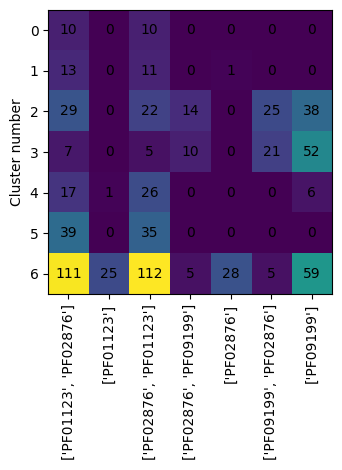

In [66]:
final_map = []
for i in range(7):
    domains_count = np.sum(domains[cluster_des_flatten == i, 1:], axis = 0)
    final_map.append(domains_count)
    for idx, j in enumerate(domains_count):
        plt.text(idx, i, j, ha="center", va="center")
plt.xticks(ticks = range(7), labels=domain_names, rotation = 90)
plt.ylabel('Cluster number')
plt.imshow(np.array(final_map).astype(float))
plt.tight_layout()
plt.savefig('cluster_distribution.png')